In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
os.chdir('Reddit_ML')

In [3]:
import bz2
import json
import pandas as pd

In [4]:
filename = 'RC_2015-01.bz2'

In [5]:
with bz2.open(filename, "rt") as bzinput:
    lines = []
    for i, line in enumerate(bzinput):
        if i == 200000:
            break
        reddit = json.loads(line)
        lines.append(reddit)

In [6]:
df = pd.DataFrame(lines)

In [7]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.1740562534923026 GB'

In [8]:
print(df.shape)
df.head().T

(200000, 21)


,0,1,2,3,4
score_hidden,False,False,False,False,False
name,t1_cnas8zv,t1_cnas8zw,t1_cnas8zx,t1_cnas8zy,t1_cnas8zz
link_id,t3_2qyr1a,t3_2qv6c6,t3_2qxefp,t3_2qys4x,t3_2qm5bi
body,Most of us have some family members like this....,But Mill's career was way better. Bentham is l...,"Mine uses a strait razor, and as much as i lov...",[deleted],"Very fast, thank you!"
downs,0,0,0,0,0
created_utc,1420070400,1420070400,1420070400,1420070400,1420070400
score,14,3,1,1,2
author,YoungModern,RedCoatsForever,vhisic,[deleted],Mastersimpson
distinguished,None,None,None,None,None
id,cnas8zv,cnas8zw,cnas8zx,cnas8zy,cnas8zz


In [9]:
import re
import string

import pandas as pd
import feather
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine, euclidean

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse


import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [10]:
df = df[df.body != '[deleted]']
df = df[df.body != '[removed]']
df = df[df.body != '']
print(df.shape)
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

(187222, 21)


'0.16652627378702228 GB'

# **Copy of DF**

In [11]:
copy = df.copy()

In [12]:
second_copy = df.copy()

# **Data Preprocessing**

In [13]:
df.distinguished.replace(to_replace=[None], value='user', inplace=True)
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)

# **Feature Engineering**

In [14]:
df.dropna()

,score_hidden,name,link_id,body,downs,created_utc,score,author,distinguished,id,archived,parent_id,subreddit,author_flair_css_class,author_flair_text,gilded,retrieved_on,ups,controversiality,subreddit_id,edited
1,False,t1_cnas8zw,t3_2qv6c6,But Mill's career was way better. Bentham is l...,0,1420070400,3,RedCoatsForever,user,cnas8zw,False,t1_cnas2b6,CanadaPolitics,on,Ontario,0,1425124282,3,0,t5_2s4gt,False
8,False,t1_cnas903,t3_2qyizj,:D.,0,1420070400,1,slicked9778,user,cnas903,False,t1_cnas8bm,BostonBruins,BartkowskiMatt,LA Kings fan,0,1425124282,1,0,t5_2rmt9,False
10,False,t1_cnas906,t3_2qyl4w,says you my g,0,1420070400,2,thebasedyeezus,user,cnas906,False,t1_cnas7u7,hiphopheads,django,,0,1425124282,2,0,t5_2rh4c,False
13,False,t1_cnas909,t3_2qup35,You mean the village hidden in filler complain...,0,1420070401,2,noitnemid,user,cnas909,False,t1_cnald9n,Naruto,deihand,,0,1425124282,2,0,t5_2quts,False
14,False,t1_cnas90a,t3_2qyp3l,I always forget how to bold on mobile.,0,1420070401,2,highvoltorb,user,cnas90a,False,t1_cnas1fe,hockey,CBJAlt1NHL,CBJAlt1NHL,0,1425124282,2,0,t5_2qiel,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199986,False,t1_cnawl5e,t3_2qyjqv,exciting overtime - great block by Polak\n,0,1420080960,1,MoreHtsThnSadaharuOh,user,cnawl5e,False,t3_2qyjqv,hockey,TOROld3NHL,TOROld3NHL,0,1425122260,1,0,t5_2qiel,False
199987,False,t1_cnawl5f,t3_2qy3j3,"""If only my balls were made of usb...""",0,1420080960,2,jwapplephobia,user,cnawl5f,False,t1_cnameke,pcmasterrace,i-desk,i5-4670k / GTX 770 / 8GB RAM / Glorious 900p,0,1425122260,2,0,t5_2sgp1,False
199990,False,t1_cnawl5i,t3_2qy4ma,"Nah, we need you to be 8th seed, please and th...",0,1420080960,2,ImHalfAwake,user,cnawl5i,False,t1_cnalprs,nba,Warriors1,[GSW] Stephen Curry,0,1425122260,2,0,t5_2qo4s,False
199991,False,t1_cnawl5j,t3_2qz29h,Looks great! With that base you can pretty muc...,0,1420080960,1,graveyardgirl,user,cnawl5j,False,t3_2qz29h,FancyFollicles,lightcoral,"Wavy, Brunette, Thick, Long",0,1425122260,1,0,t5_2sa9a,False


In [15]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.1729479871713743 GB'

In [16]:
df.distinguished.replace(to_replace=[None], value='user', inplace=True)
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)

In [17]:
df['subreddit'] = df.subreddit.astype('category')
df['subreddit_id'] = df.subreddit_id.astype('category')
df['distinguished'] = df.distinguished.astype('category')
df['link_id'] = df.link_id.astype('category')

In [18]:
# The number of hours between when the comment was posted & when it was scraped
t = (df.retrieved_on - df.created_utc.astype(str).astype(int)) / 60 / 60
t.min()

1400.361111111111

In [19]:
# Remove superfluous explanatory variables
df.drop(['archived', 'retrieved_on', 'id'], axis=1, inplace=True)
print(df.shape)
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

(187222, 18)


'0.12181047026725363 GB'

In [20]:
# Replace 'NaN' with 'user'
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)

# **Recency Based Features**

In [21]:
df['time'] = pd.to_datetime(df.created_utc, unit='s')

In [22]:
# Find the time of the first comment in a thread
df_first_comment = df[['link_id', 'time']].groupby(by=['link_id']).min()

# Create a dictionary of {link_id -> timestamp} pairs
df_first_comment_dict = df_first_comment.to_dict('index')

# Funct that takes in {link_id, timestamp} pair & returns the time elapsed since the first comment in that link_id.
def time_lapse(x):
    return df_first_comment_dict[x]['time']

# Add a column of the time_elapsed from the first comment in a link_id
df['time_lapse'] = df.time - df.link_id.apply(time_lapse)

# Convert the type of time_lapse back to seconds
df.time_lapse = df.time_lapse.apply(lambda x: x.total_seconds())

df['hour_of_comment'] = df.time.apply(lambda x: x.hour)
df['weekday'] = df.time.dt.weekday

In [23]:
# Total comments / unique threads 
len(df.link_id) / len(df.link_id.unique())

4.4302413629910085

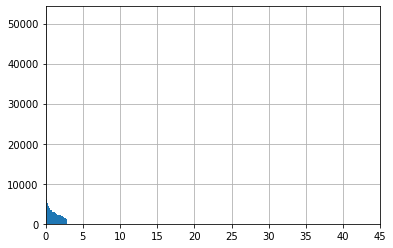

In [24]:
# hours after first comment in thread
(df.time_lapse / (60*60)).hist(bins=50).set_xlim((0, 45));

# **Comment Appearance Based Feautures**

In [25]:
df['is_flair'] = ~df.author_flair_text.apply(lambda x: x is None)
df['is_flair_css'] = ~df.author_flair_css_class.apply(lambda x: x is None)

print(sum(df.is_flair) / len(df.is_flair))
print(sum(df.is_flair_css) / len(df.is_flair_css))
0.007156374534157479

0.3968123404300777
0.39421115039899157


0.007156374534157479

In [26]:
def pd_to_dict(df, index='', column=''):
    return pd.Series(df[column].values, index=df[index]).to_dict()

comment_to_parent_dict = pd_to_dict(df[['name', 'parent_id']],
                                    index='name', column='parent_id')

def get_depth(x):
    counter = 0
    temp = x
    while True:
        if temp[:3] == 't3_':
            return counter
        try:
            temp = comment_to_parent_dict[temp]
        except KeyError:
            return counter
        counter += 1
        
df['depth'] = df['name'].apply(get_depth)
comment_to_score = pd_to_dict(df[['name', 'score']],
                              index='name', column='score')

def get_parent_score(x):
    try:
        return comment_to_score[x]
    except:
        return np.nan

df['parent_score'] = df.parent_id.apply(lambda x: get_parent_score(x))
# imp_val = df.parent_score.median()
# df.parent_score.fillna(imp_val, inplace=True)

comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

def get_time_since_parent(pi):
    try:
        return comment_to_time[pi]
    except:
        return np.nan

df['time_since_parent'] = df.parent_id.apply(get_time_since_parent)
df.loc[df.time_since_parent.isna(), 'time_since_parent'] = df.time
df.time_since_parent = df.time - df.time_since_parent
df.time_since_parent = df.time_since_parent.apply(lambda x: x.total_seconds())

In [27]:
sum(df.parent_score != df.parent_score) / len(df.parent_score)

0.6984008289624083

# **Comment Tree Based Features**

In [28]:
def get_comment_tree_root(x):
    if comment_to_parent_dict[x][:3] == 't3_':
        return x
    try:
        return get_comment_tree_root(comment_to_parent_dict[x])
    except KeyError:
        return np.nan
    
comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

def get_time(x):
    try:
        return comment_to_time[x]
    except:
        return np.nan
    
df['comment_tree_root_id'] = df.name.apply(get_comment_tree_root)
df['comment_tree_root_score'] = df.comment_tree_root_id.apply(lambda x: get_parent_score(x))
df['time_since_comment_tree_root'] = df.time - df.comment_tree_root_id.apply(get_time)
df.time_since_comment_tree_root = df.time_since_comment_tree_root.apply(lambda x: x.total_seconds())

In [29]:
print(sum(df.comment_tree_root_id == df.name) / len(df.depth))

0.40289068592366284


# **Comment Content Based Features**

In [30]:
# Extract an array of subreddit links in a post & use as a feature
df['linked_sr'] = df.body.apply(lambda x: re.findall(r"/r/([^\s/]+)", x))

# Remove the subreddits mentioned from the actual comment
df['body'] = df.body.apply(lambda x: re.sub(r"(/r/[^\s/]+)", '', x))

In [31]:
# Nasty Regular Extraction to extract a link
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def get_domains(x):
    """
    Given a comment (String), extract an array of urls' domain names mentioned in the comment
    """
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    urls = re.findall(url_regex, x)
    try:
        domain_names = [urlparse(url).netloc.split('.')[-2] for url in urls]
    except:
        return []
    return domain_names

# Create the feature for each observation
df['linked_urls'] = df.body.apply(lambda x: get_domains(x))

In [32]:
def remove_urls(x):
    """
    Given a comment, replace the url component with an empty string. 
    """
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    return re.sub(url_regex, '', x)

# Remove the URL from each comment 
df['body'] = df.body.apply(lambda x: remove_urls(x))

### **no_of_linked_sr & no_of_linked_urls**

In [33]:
# Create a how-many-subreddit-links-were-in-this-comment? feature
df['no_of_linked_sr'] = df['linked_sr'].apply(lambda x: len(x))

# Create a how-many-urls-were-in-this-comment? feature
df['no_of_linked_urls'] = df['linked_urls'].apply(lambda x: len(x))

In [34]:
print(f"Subreddit-links-per-post  {sum(df.no_of_linked_sr) / len(df.body)}")
print(f"URL-links-per-post        {sum(df.no_of_linked_urls) / len(df.body)}")

Subreddit-links-per-post  0.03968016579248165
URL-links-per-post        0.09859418230763478


In [35]:
all_linked_sr = []
for l in df.linked_sr.values:
    all_linked_sr += l

top_sr_links = Counter(all_linked_sr)
top_sr_links.most_common(15)

[('AutoModerator', 991),
 ('autowikibot', 237),
 ('havoc_bot', 188),
 ('AskReddit', 185),
 ('Jokes', 120),
 ('trees', 120),
 ('mildlyinteresting', 107),
 ('havoc_bot)', 94),
 ('videos', 90),
 ('AskScienceFiction', 85),
 ('WritingPrompts', 84),
 ('Fitness', 83),
 ('kpop', 78),
 ('HFY', 63),
 ('GlobalOffensiveTrade', 56)]

In [36]:
all_linked_urls = []
for l in df.linked_urls.values:
    all_linked_urls += l

top_url_links = Counter(all_linked_urls)
top_url_links.most_common(15)

[('reddit', 3564),
 ('imgur', 2372),
 ('wikipedia', 1672),
 ('youtube', 1420),
 ('tumblr', 954),
 ('pcpartpicker', 495),
 ('google', 297),
 ('youtu', 285),
 ('twitter', 227),
 ('redd', 227),
 ('github', 218),
 ('steamcommunity', 185),
 ('wizards', 183),
 ('amazon', 160),
 ('co', 121)]

In [37]:
# Find the most common URLs
allowed_urls = [i[0] for i in top_url_links.most_common(15)]

def remove_urls(x):
    """
    Given a list of URLs, keep only those in the top-15. 
    """
    y = []
    for i in x:
        if i in allowed_urls:
            y += [i]
    return y

# Keep only the popular URLs 
df['linked_urls'] = df['linked_urls'].apply(lambda x: remove_urls(x))

In [38]:
# Implement the above
df['subjectivity'] = df['body'].str.count('I ')

In [39]:
# Create a column indicating if the comment is edited or not
df['is_edited'] = df.edited.apply(lambda x: x > 0)

In [40]:
f"Edited/All = {sum(df.is_edited) / len(df.is_edited)}"

'Edited/All = 0.02497569730053092'

In [41]:
# if the comment quotes another comment, indicate that with a boolean
df['is_quoted'] = df.body.str.contains('&gt;')

In [42]:
# Implement the above
df['no_quoted'] = df.body.str.count('&gt;')

In [43]:
print(f"Subreddit-links-per-post  {sum(df.no_of_linked_sr) / len(df.body)}")
print(f"URL-links-per-post        {sum(df.no_of_linked_urls) / len(df.body)}")

Subreddit-links-per-post  0.03968016579248165
URL-links-per-post        0.09859418230763478


In [44]:
f"Edited/All = {sum(df.is_edited) / len(df.is_edited)}"

'Edited/All = 0.02497569730053092'

In [45]:
top_sr_links.most_common(15)

[('AutoModerator', 991),
 ('autowikibot', 237),
 ('havoc_bot', 188),
 ('AskReddit', 185),
 ('Jokes', 120),
 ('trees', 120),
 ('mildlyinteresting', 107),
 ('havoc_bot)', 94),
 ('videos', 90),
 ('AskScienceFiction', 85),
 ('WritingPrompts', 84),
 ('Fitness', 83),
 ('kpop', 78),
 ('HFY', 63),
 ('GlobalOffensiveTrade', 56)]

In [46]:
top_url_links.most_common(15)

[('reddit', 3564),
 ('imgur', 2372),
 ('wikipedia', 1672),
 ('youtube', 1420),
 ('tumblr', 954),
 ('pcpartpicker', 495),
 ('google', 297),
 ('youtu', 285),
 ('twitter', 227),
 ('redd', 227),
 ('github', 218),
 ('steamcommunity', 185),
 ('wizards', 183),
 ('amazon', 160),
 ('co', 121)]

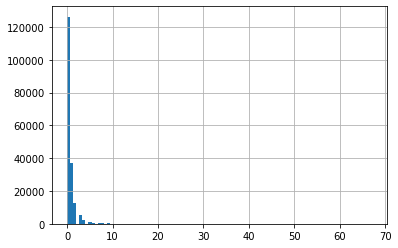

In [47]:
df.subjectivity.hist(bins=100)
plt.show()

# **Sentiment Based Features**

In [48]:
 !pip install vaderSentiment

In [49]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# sentiment analyzer
analyser = SentimentIntensityAnalyzer() # http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html

# get sentiment scores 
def get_sentiment(x):
    return analyser.polarity_scores(x)

# get sentiment scores from 'body' column of dataframe
def wrapper_get_sentiment(df):
    df['sentiment'] = df['body'].apply(get_sentiment)
    return df

# to apply operation in parallel
num_partitions = 100
num_cores = 4
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# add a column for each score to our data
sentiment = parallelize_dataframe(df['body'].to_frame(), wrapper_get_sentiment)
sentiment.drop(['body'], axis=1, inplace=True)
df['senti_neg'] = sentiment['sentiment'].apply(lambda x: x['neg'])
df['senti_neu'] = sentiment['sentiment'].apply(lambda x: x['neu'])
df['senti_pos'] = sentiment['sentiment'].apply(lambda x: x['pos'])
df['senti_comp'] = sentiment['sentiment'].apply(lambda x: x['compound'])
del sentiment

In [50]:
print(df.shape)


(187222, 42)


# **Comment Length Based Features**

In [51]:
# get number of words in comment
def get_word_count(df):
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))
    return df

word_counts = parallelize_dataframe(df['body'].to_frame(), get_word_count)
df['word_counts'] = word_counts.word_count
del word_counts

In [52]:
print(df.shape)

(187222, 43)


# **Add thread level data**

In [53]:
processed_data = df.copy()

In [54]:
scraped_data = pd.read_csv('ScrapedDF_final.csv')

In [55]:
scraped_data.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
sub_id,t3_2qyr1a,t3_2qxefp,t3_2qm5bi,t3_2qxlvm,t3_2qy7at
created_utc,1.42007e+09,1.42004e+09,1.41977e+09,NaN,1.42006e+09
distinguished,NaN,NaN,NaN,NaN,NaN
edited,False,False,1420315336.0,NaN,False
locked,False,False,False,NaN,False
url,https://www.reddit.com/r/exmormon/comments/2qy...,https://imgur.com/3e8DBss,https://www.reddit.com/r/freedonuts/comments/2...,NaN,http://i.imgur.com/iFyrpSE.jpg
num_comments,24.0,64.0,42.0,NaN,2.0
over_18,False,False,False,NaN,False
score,35,1398,10,NaN,0


In [56]:
del scraped_data['Unnamed: 0']
del scraped_data['Unnamed: 0.1']

In [57]:
scraped_data.shape

(29257, 18)

In [58]:
scraped_data['url'] = scraped_data.url.astype('category')
scraped_data['selftext'] = scraped_data.selftext.astype('category')
scraped_data['title'] = scraped_data.title.astype('category')

In [59]:
scraped_data['link_created_time'] = pd.to_datetime(scraped_data.created_utc, unit='s')

In [60]:
scraped_data.drop(['locked', 'downs', 'is_original_content',
          'view_count', 'distinguished', 'edited',
          'num_crossposts', 'spoiler', 'created_utc'], axis=1, inplace=True)

In [61]:
scraped_data.rename(columns={'sub_id':'link_id', 
                    'ups': 'link_ups',
                    'score': 'link_score'}, inplace=True)

In [62]:
scraped_data.tail().T

,29252,29253,29254,29255,29256
link_id,t3_2q7z0z,t3_2qy3ii,t3_2qz27d,t3_2qy433,t3_2qz29h
url,http://youtu.be/rRaNLeqBp2Q,https://www.reddit.com/r/personalfinance/comme...,http://www.bilder.beofnf.de/gifs/uhmm.gif,https://www.reddit.com/r/Frozen/comments/2qy43...,https://www.reddit.com/r/FancyFollicles/commen...
num_comments,19.0,15.0,8.0,1.0,6.0
over_18,False,False,False,False,False
link_score,100,12,2,6,1
selftext,NaN,Hi PF! Long time lurker and first time poster!...,[deleted],NaN,"I've been through a few different colors, but ..."
title,Good Samaritan shields woman and baby from Vio...,Advice: Credit score length of time vs. high u...,I've been hooking up with my best friend who c...,gray scale anna by Daleksyouruncle on DeviantArt,White hair for probably the fifth time. sugges...
upvote_ratio,0.84,0.73,0.57,1,0.67
link_ups,100,12,2,6,1
link_created_time,2014-12-23 22:54:51,2014-12-31 19:56:17,2015-01-01 01:52:51,2014-12-31 20:01:19,2015-01-01 01:53:37


In [63]:
f"{scraped_data.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.0246038814636963 GB'

In [64]:
df = processed_data.merge(scraped_data, on='link_id', how='left')

In [65]:
df['time_since_link'] = (df.time - df.link_created_time)
df.time_since_link = [x.total_seconds() for x in df.time_since_link]

In [66]:
df.shape

(187222, 53)

In [67]:
df.head().T

,0,1,2,3,4
score_hidden,False,False,False,False,False
name,t1_cnas8zv,t1_cnas8zw,t1_cnas8zx,t1_cnas8zz,t1_cnas900
link_id,t3_2qyr1a,t3_2qv6c6,t3_2qxefp,t3_2qm5bi,t3_2qxe1p
body,Most of us have some family members like this....,But Mill's career was way better. Bentham is l...,"Mine uses a strait razor, and as much as i lov...","Very fast, thank you!","The guy is a professional, and very good at wh..."
downs,0,0,0,0,0
created_utc,1420070400,1420070400,1420070400,1420070400,1420070400
score,14,3,1,2,6
author,YoungModern,RedCoatsForever,vhisic,Mastersimpson,BigGupp1
distinguished,user,user,user,user,user
parent_id,t3_2qyr1a,t1_cnas2b6,t3_2qxefp,t3_2qm5bi,t1_cnaqg2t


In [68]:
# drops about 2000 rows due to link_id not in scraped_data
df = df.iloc[np.where(df.title == df.title)]
print(df.shape)
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

(158712, 53)


'0.192780638507633 GB'

# **Engineer new features**

In [69]:
df['url'] = df.url.astype('str').apply(lambda x: urlparse(x)[1])
df['url'] = df.url.astype('category')
df['is_root'] = df.parent_id.str.startswith('t3_')
df.loc[df.is_root, 'comment_tree_root_score'] = np.nan # if comment is a root, comment_tree_root_score is the same as score. Can't have this
df['is_selftext'] = df.selftext.str.len() > 1

# **Comment2Vec Based Features**

# **Thread Activity Based Features**

In [72]:
df.isna().sum()

score_hidden                         0
name                                 0
link_id                              0
body                                 0
downs                                0
created_utc                          0
score                                0
author                               0
distinguished                        0
parent_id                            0
subreddit                            0
author_flair_css_class           95500
author_flair_text                95378
gilded                               0
ups                                  0
controversiality                     0
subreddit_id                         0
edited                               0
time                                 0
time_lapse                           0
hour_of_comment                      0
weekday                              0
is_flair                             0
is_flair_css                         0
depth                                0
parent_score             